In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from collections import defaultdict
import timeit

## TODO:
- create these graphs in the real data
- figure out our summary statistic...

In [2]:
def set_plots_size_params(size):
    # Adapted from https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
    bigger = size * 1.2
    slightly_bigger = size * 1.1
    plt.rc('font', size=size)                        # controls default text sizes
    plt.rc('axes', titlesize=bigger)                 # fontsize of the axes title
    plt.rc('axes', labelsize=slightly_bigger)        # fontsize of the x and y labels
    plt.rc('xtick', labelsize=size)                  # fontsize of the tick labels
    plt.rc('ytick', labelsize=size)                  # fontsize of the tick labels
    plt.rc('legend', fontsize=size)                  # legend fontsize
    plt.rc('figure', figsize=(0.75*size, size/2))    # size of figure
    return
set_plots_size_params(20)

In [3]:
def these_muts_chance(mutations, fitness_distribution):
    return np.product(np.power(fitness_distribution, mutations))


def get_mutation_probs(mutation_rate, min_freq):
    probs = dict()
    for num_of_muts in range(20):
        prob = poisson.pmf(num_of_muts, mutation_rate)
        if prob <= min_freq:
            break
        probs[num_of_muts] = prob
    return probs


def get_mutations(mutation_rate, fitness_distribution, min_freq, max_mutations=20):
    possible_mutations = []
    for a1 in range(max_mutations+1):
        for a2 in range(max_mutations+1):
            for a3 in range(max_mutations+1):
                perm = (a1,a2,a3)
                if sum(perm)>max_mutations or perm in possible_mutations:
                    continue
                possible_mutations.append(perm)
    possible_mutations = tuple(possible_mutations)
    this_many_muts_chance = get_mutation_probs(mutation_rate, min_freq)
    mutations_prob = dict()
    for mut_tuple in possible_mutations:
        num_of_muts = sum(mut_tuple)
        if num_of_muts in this_many_muts_chance.keys():  
            mut_prob = this_many_muts_chance[num_of_muts] * these_muts_chance(mut_tuple, fitness_distribution)
            if mut_prob > min_freq:
                mutations_prob[mut_tuple] = mut_prob
    return mutations_prob

In [4]:
def simulate_next_passage_comprehensible(fitness_values, genotype_freqs, mutation_probabilities, min_freq):
    # this is slow but comprehensible
    new_freqs = defaultdict(float)
    for genotype, freq in genotype_freqs.items():
        for mutation, mut_freq in mutation_probabilities.items():
            new_genotype = tuple(np.add(genotype, mutation).tolist())
            fitness = np.product(np.power(fitness_values, new_genotype))
            new_freq = freq * mut_freq * fitness
            new_freqs[new_genotype] += new_freq
    new_freqs = pd.Series(new_freqs)
    new_freqs /= sum(new_freqs)
    return new_freqs[new_freqs > min_freq]

In [39]:
def simulate_next_passage_fast(fitness_values, genotype_freqs, mutations, mutations_freqs, min_freq):
    # turn dict into arrays:
    genotypes = np.array(list(genotype_freqs.keys()), dtype=int)
    genotypes_freqs = np.array(list(genotype_freqs.values()), dtype=float)
    # do that numpy magic:
    new_genotypes = genotypes.reshape(-1,1,3) + mutations
    new_freqs = genotypes_freqs.reshape(-1,1,1) * mutations_freqs
    fitness = np.product(np.power(fitness_values, new_genotypes), axis=2)
    new_genotypes = map(tuple, new_genotypes.reshape(-1,3))
    new_freqs = new_freqs.reshape(-1) * fitness.reshape(-1)
    # turn back into dict:
    freqs_dict = defaultdict(float)
    for mut, freq in zip(new_genotypes, new_freqs):
        freqs_dict[mut] += freq
    freqs_sum = sum(freqs_dict.values())
    freqs_dict = {key: val/freqs_sum for key, val in freqs_dict.items()}
    freqs_dict = {key: val for key, val in freqs_dict.items() if val>min_freq}
    return freqs_dict


def model(fitness_distribution, fitness_values, mutation_rate, passages,  virions_num=10**10):
    passage = dict()
    passage[0] = {(0,0,0) :1}
    min_freq = 1/virions_num
    mutation_probabilities = get_mutations(mutation_rate, fitness_distribution, min_freq)
    mutations = np.array(list(mutation_probabilities.keys()), dtype=int).reshape(1,-1,3)
    mutations_freqs = np.array(list(mutation_probabilities.values()), dtype=float).reshape(1,-1,1)
    for i in range(passages):
        passage[i+1] = simulate_next_passage_fast(fitness_values, passage[i], mutations, mutations_freqs, 
                                                  min_freq)
    return pd.DataFrame(passage)

In [220]:
def genome_freq_plot(data, genomes_to_plot, ax):
    ax.set_title('High Freq Genomes')
    rising_muts = data.sort_values(by=data.columns.max(), ascending=False).head(genomes_to_plot).index
    ax.plot(data.loc[(0,0,0), 0:], label='ref', marker='*')
    adaptive_1 = data[data.index.get_level_values(2)==1].sum()
    adaptive_2 = data[data.index.get_level_values(2)==2].sum()
    ax.plot(adaptive_1.index, adaptive_1, label='sum adaptive 1', marker='*', linestyle='--')
    ax.plot(adaptive_2.index, adaptive_2, label='sum adaptive 2', marker='*', linestyle='--')
    for mut in rising_muts:
        if mut == (0,0,0):
            continue
        ax.plot(data.loc[mut, 0:], label=mut, marker='*')
    ax.legend(bbox_to_anchor=(-0.1,1.05))


def mutations_per_genome_plot(data, passages_to_plot, ax):
    data['mut_num'] = [sum(x) for x in data.index]
    ax.set_title('Mutations Per Genome')
    for i in passages_to_plot:
        num_of_muts = data[data[i].notna()].groupby('mut_num')[i].sum()
        sns.scatterplot(data=num_of_muts, label=f'passage {i}', ax=ax)
        sns.lineplot(data=num_of_muts, ax=ax)
    ax.set_ylabel('')
    
    
def plot_data(data, genomes_to_plot, passages_to_plot):
    fig, axes = plt.subplots(1, 2, figsize=(20,7))
    genome_freq_plot(data, genomes_to_plot, axes[0])
    mutations_per_genome_plot(data, passages_to_plot, axes[1])

In [221]:
def run_n_plot(fitness_distribution, fitness_values, mutation_rate, passages=10, genomes_to_plot=10, 
               passages_to_plot=[3,7,10]):
    data = model(fitness_distribution, fitness_values, mutation_rate, passages)
    plot_data(data, genomes_to_plot, passages_to_plot)
    return data

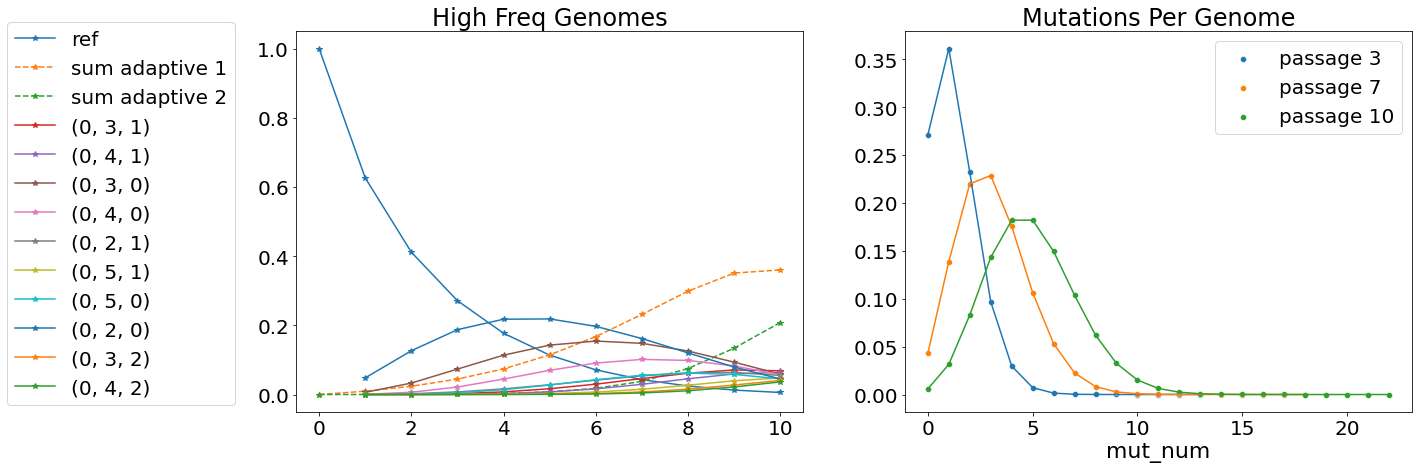

In [222]:
fitness_distribution = np.array([0.5, 0.49, 0.01])
fitness_values = np.array([0.2, 1, 1.5])
mutation_rate = 0.8
passages = 10
passages_to_plot = [3,7,10]
genomes_to_plot = 10

data = run_n_plot(fitness_distribution, fitness_values, mutation_rate, passages, genomes_to_plot, passages_to_plot)

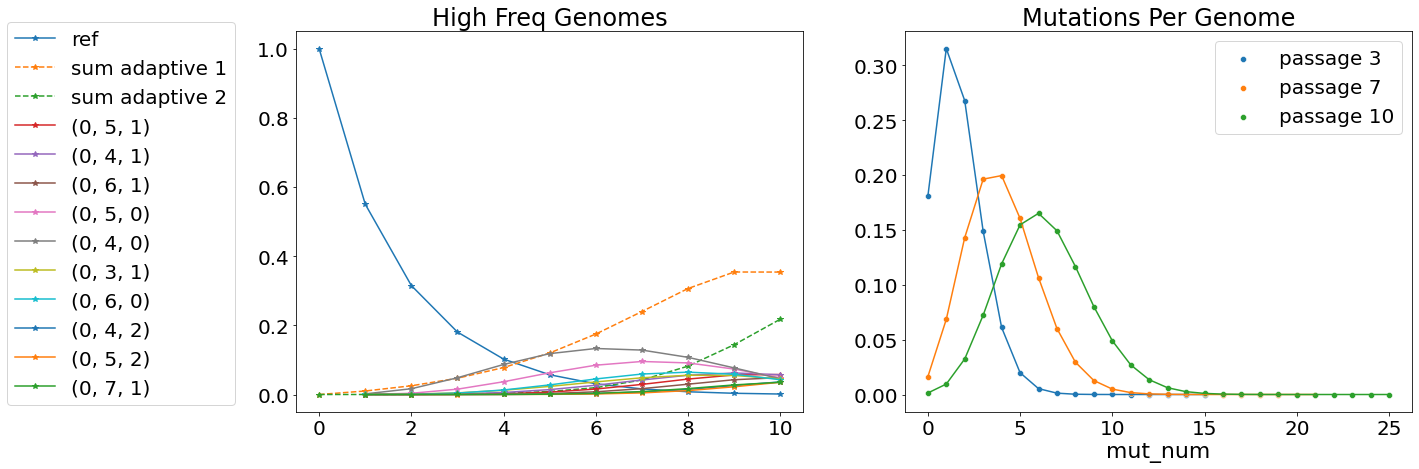

In [230]:
fitness_distribution = np.array([0.4, 0.59, 0.01])
fitness_values = np.array([0.2, 1, 1.5])
mutation_rate = 0.9
passages = 10
passages_to_plot = [3,7,10]
genomes_to_plot = 10

data = run_n_plot(fitness_distribution, fitness_values, mutation_rate, passages, genomes_to_plot, passages_to_plot)

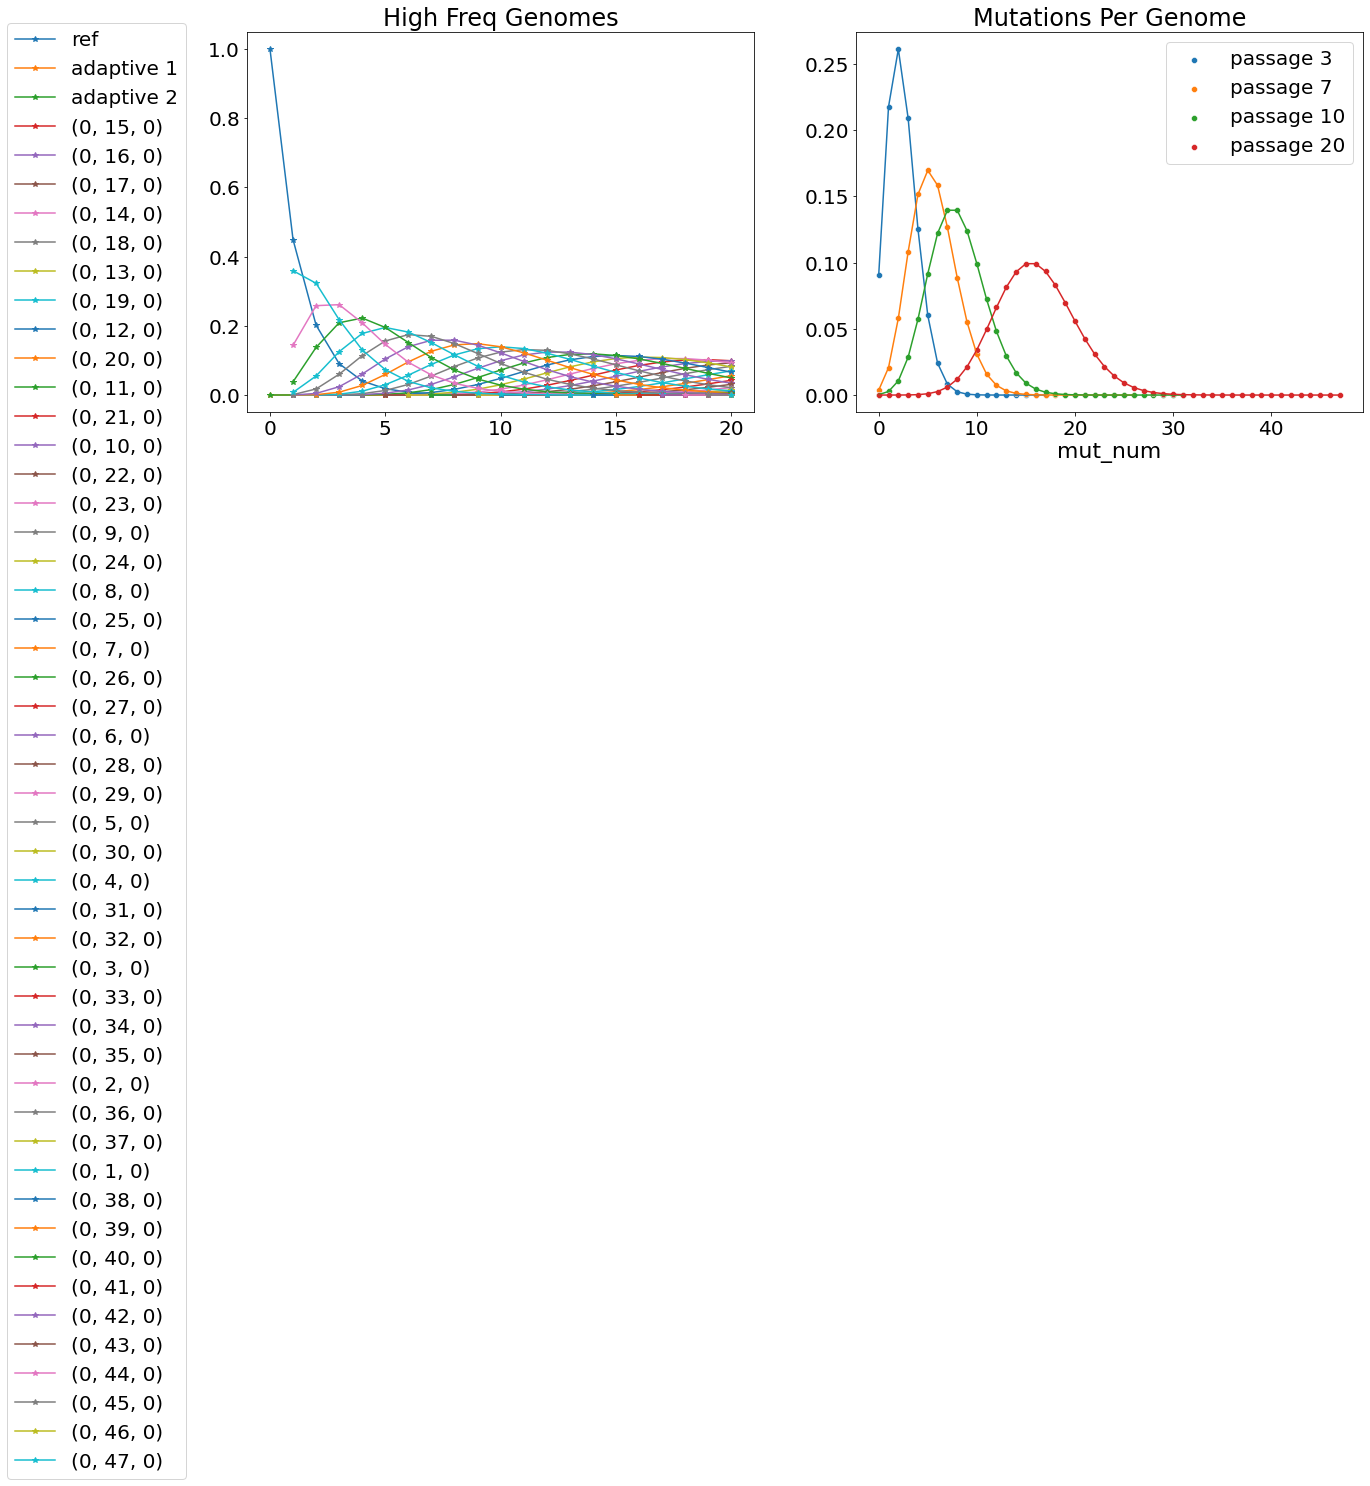

In [216]:
fitness_distribution = np.array([0, 1, 0])
fitness_values = np.array([0.2, 1, 1.2])
genomes_to_plot = 50
passages = 20
passages_to_plot = [3,7,10,20]
data = run_n_plot(fitness_distribution, fitness_values, mutation_rate, passages, genomes_to_plot, passages_to_plot)

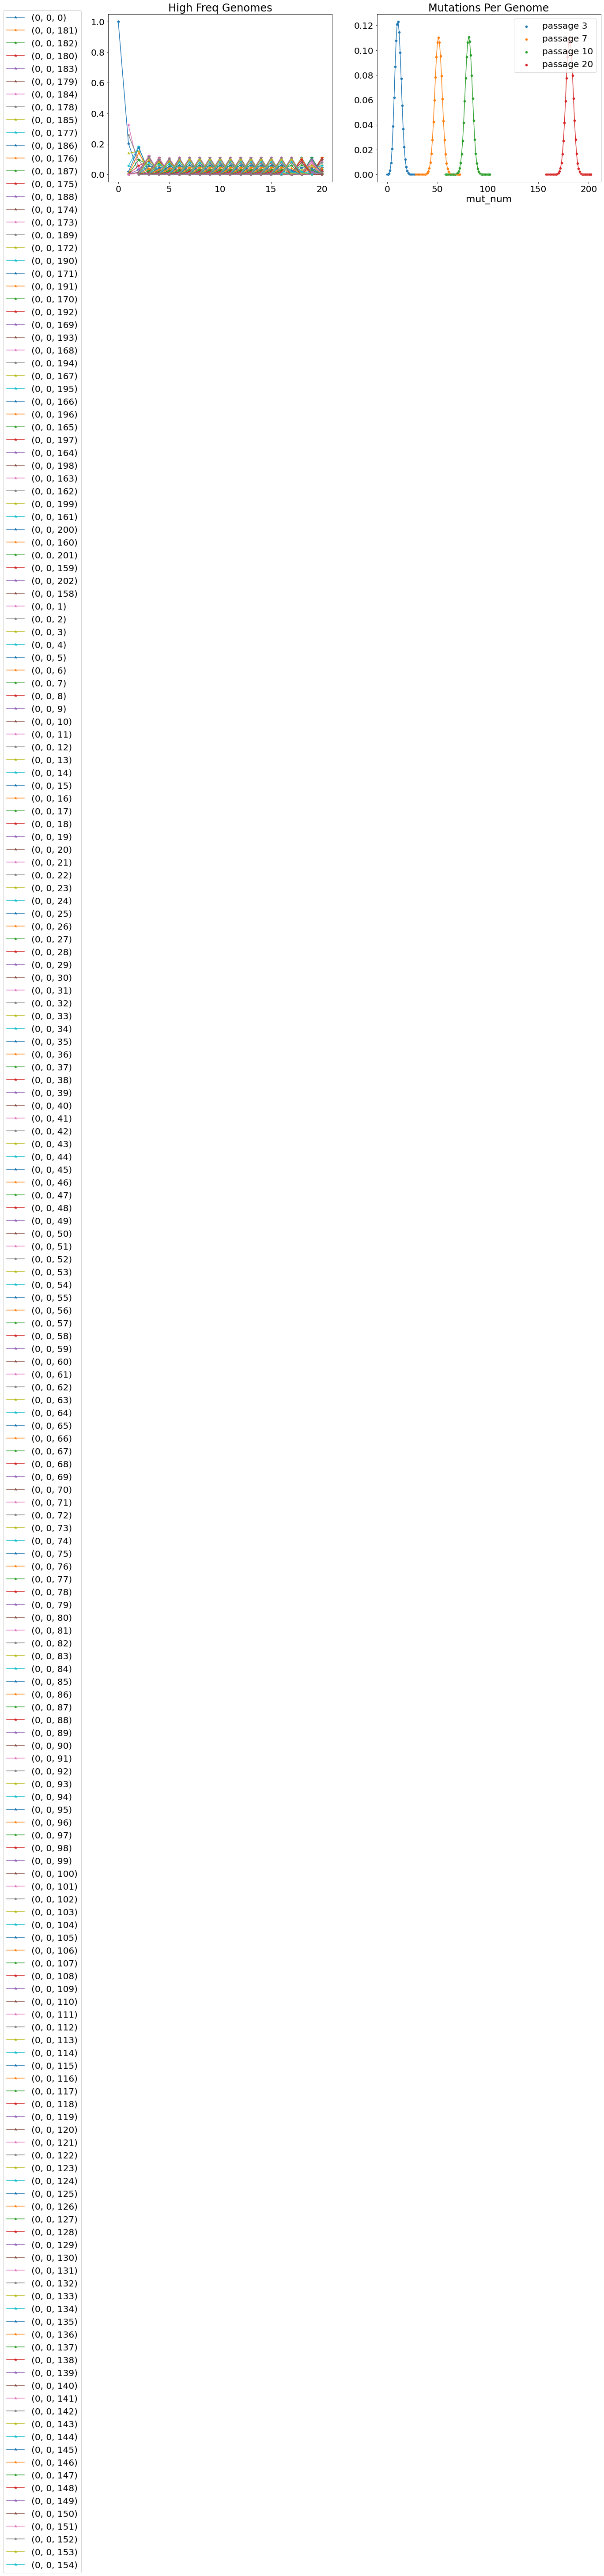

In [167]:
fitness_distribution = np.array([0, 0, 1])
fitness_values = np.array([0.2, 1,2])
passages = 20
genomes_to_plot = 200
data = run_n_plot(fitness_distribution, fitness_values, mutation_rate, passages, genomes_to_plot, passages_to_plot)

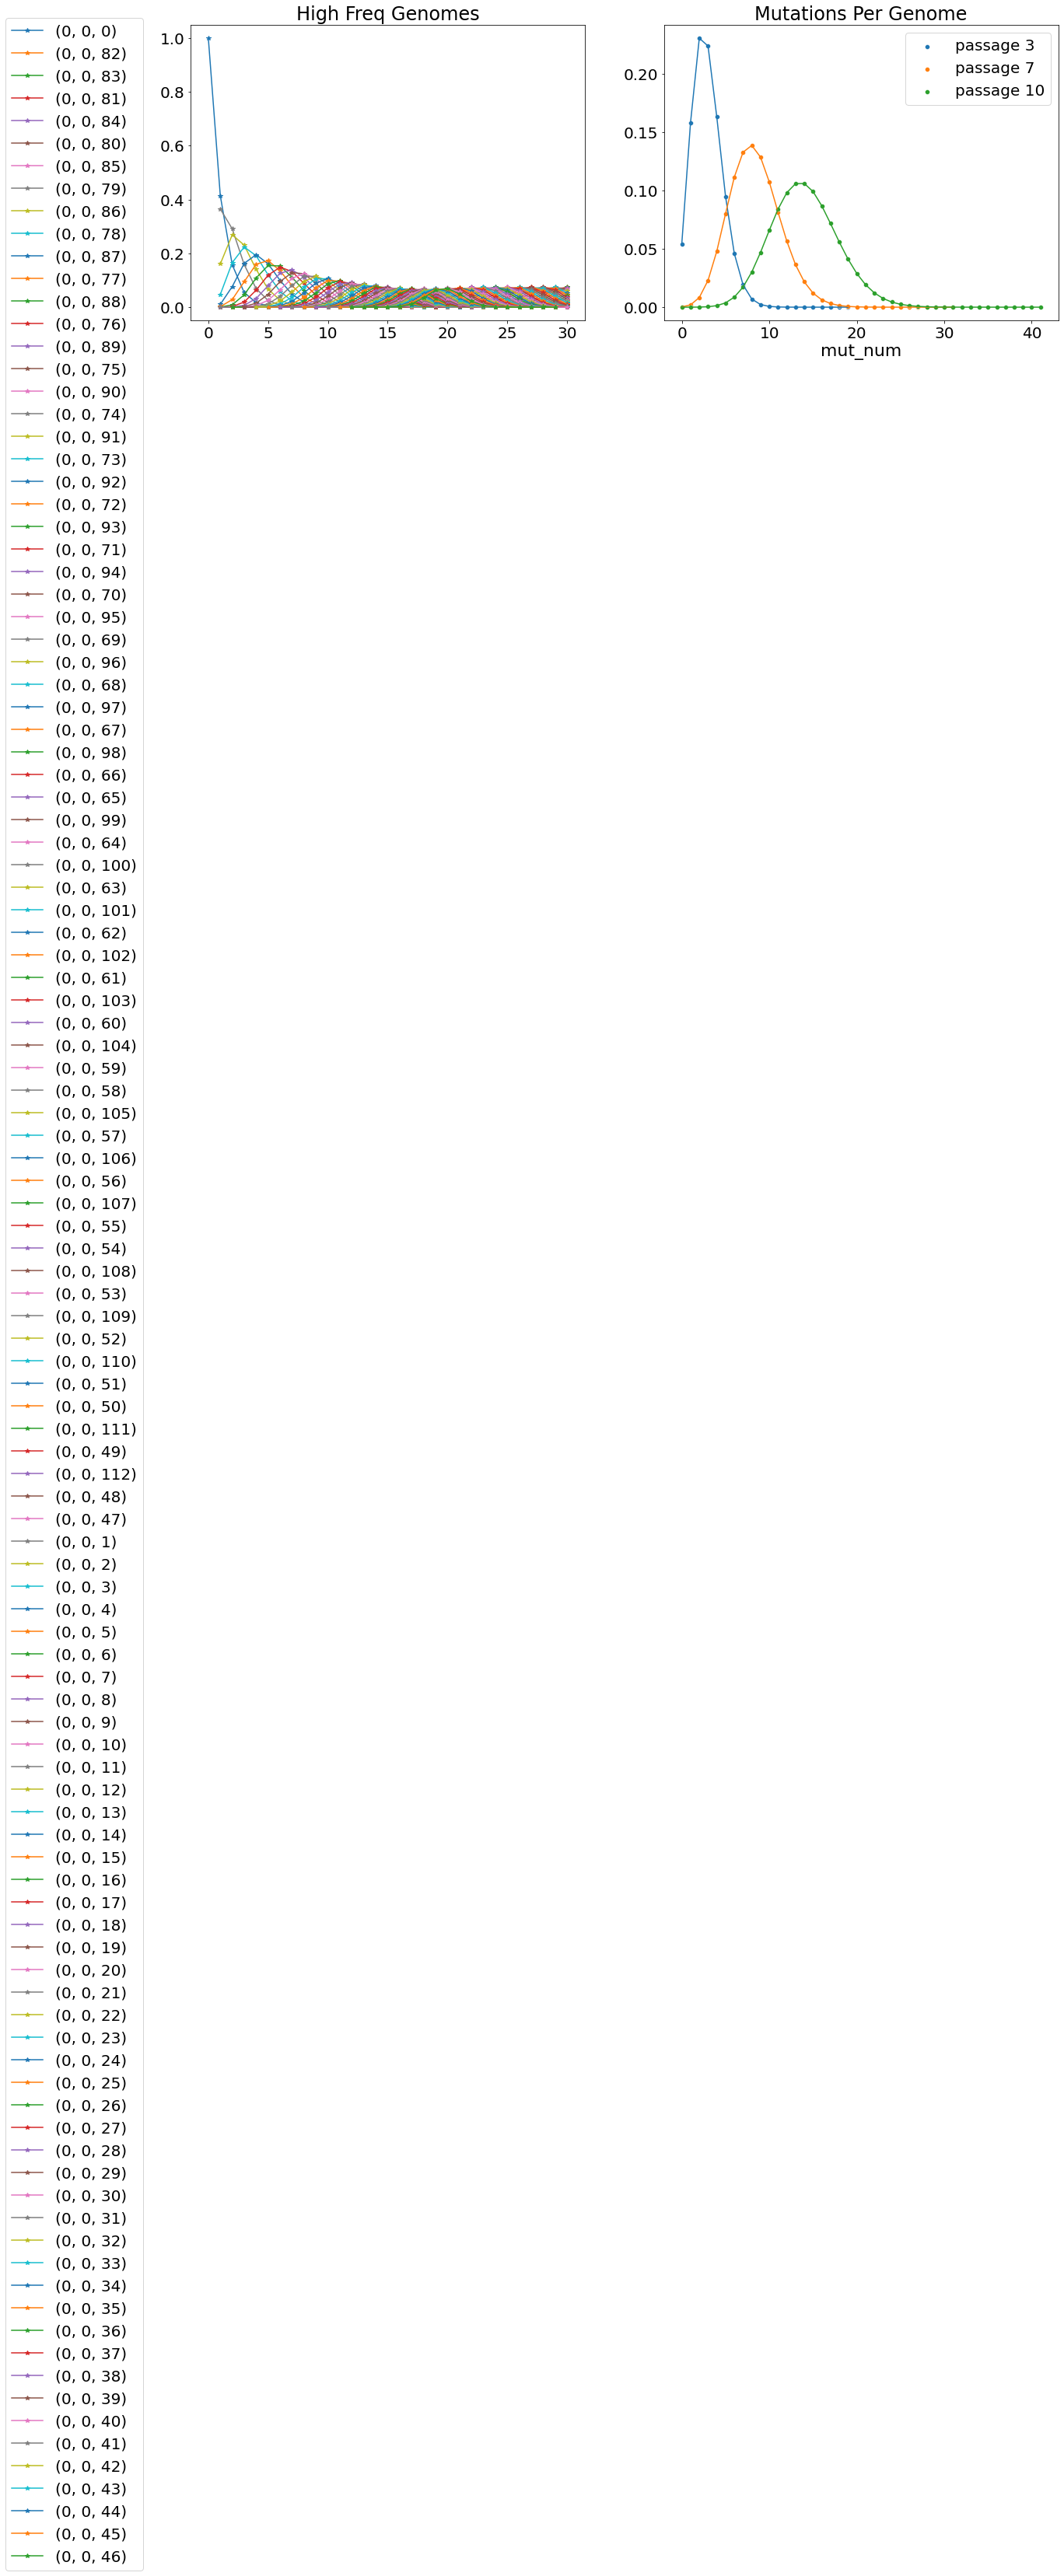

In [176]:
fitness_distribution = np.array([0, 0, 1])
fitness_values = np.array([0.2, 1, 1.1])
passages = 30
genomes_to_plot = 200
data = run_n_plot(fitness_distribution, fitness_values, mutation_rate, passages, genomes_to_plot, passages_to_plot)

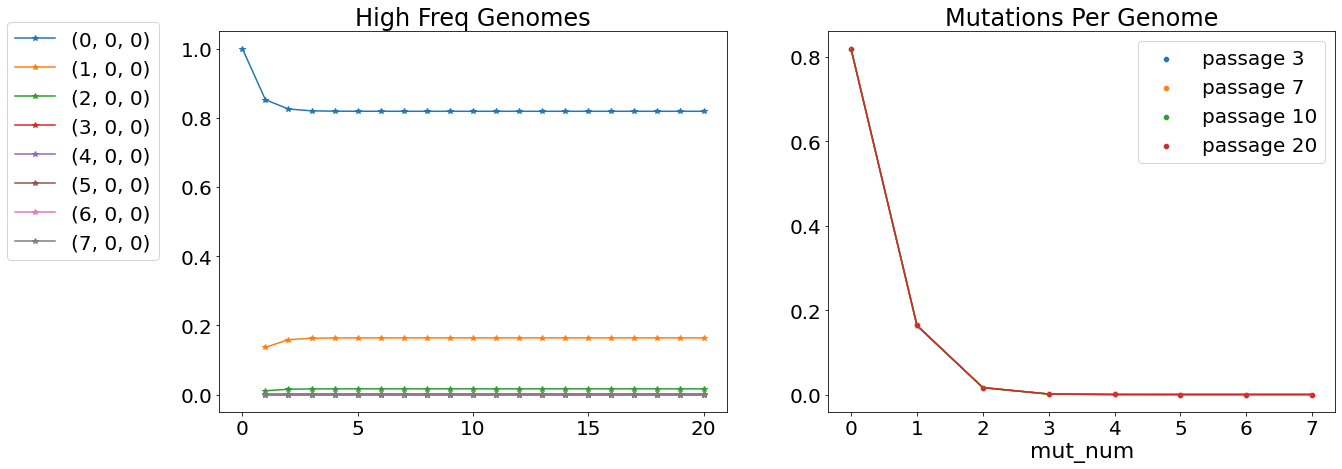

In [169]:
fitness_distribution = np.array([1, 0, 0])
fitness_values = np.array([0.2, 1, 1.1])
passages = 20
genomes_to_plot = 200
data = run_n_plot(fitness_distribution, fitness_values, mutation_rate, passages, genomes_to_plot, passages_to_plot)

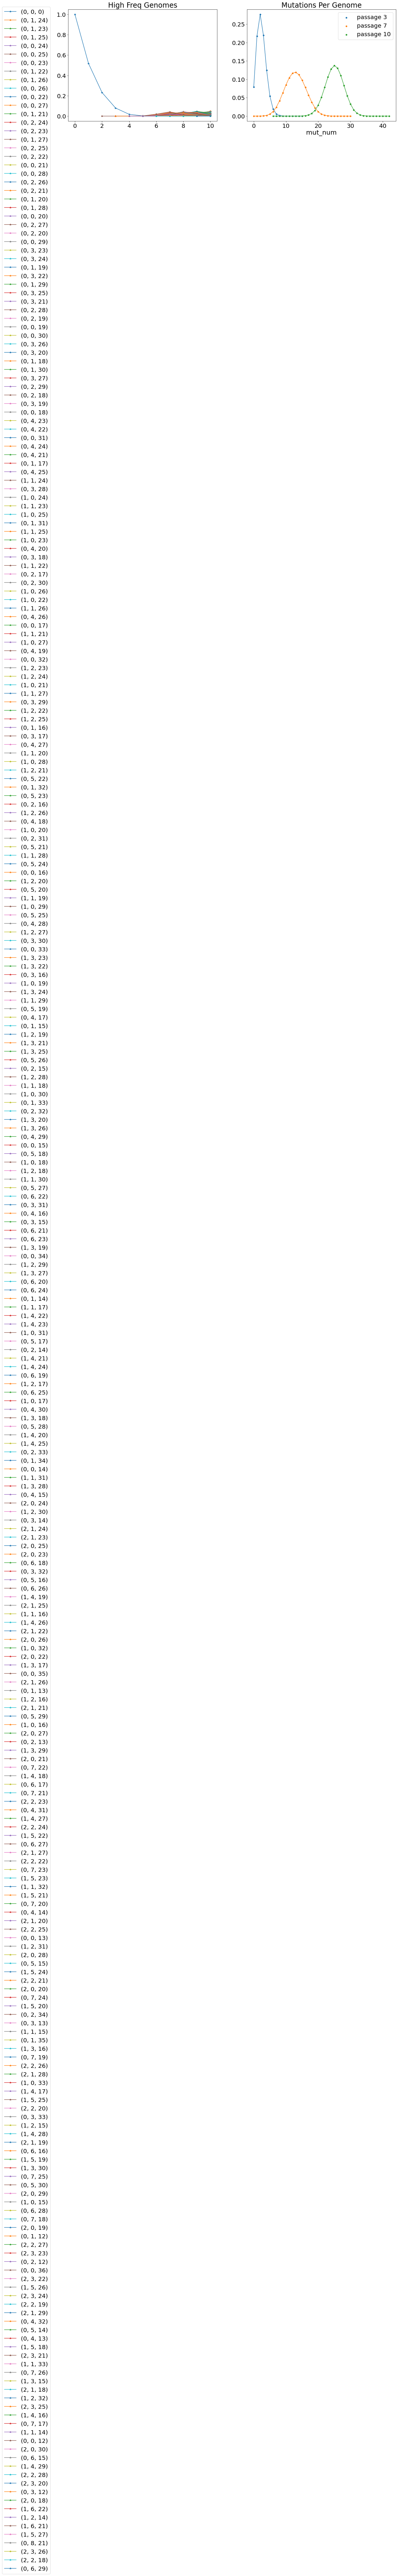

In [174]:
fitness_distribution = np.array([0.33, 0.33, 0.33])
fitness_values = np.array([0.2, 1, 1.5])
passages = 10
genomes_to_plot = 300
passages_to_plot = [3,7,10]
data = run_n_plot(fitness_distribution, fitness_values, mutation_rate, passages, genomes_to_plot, passages_to_plot)

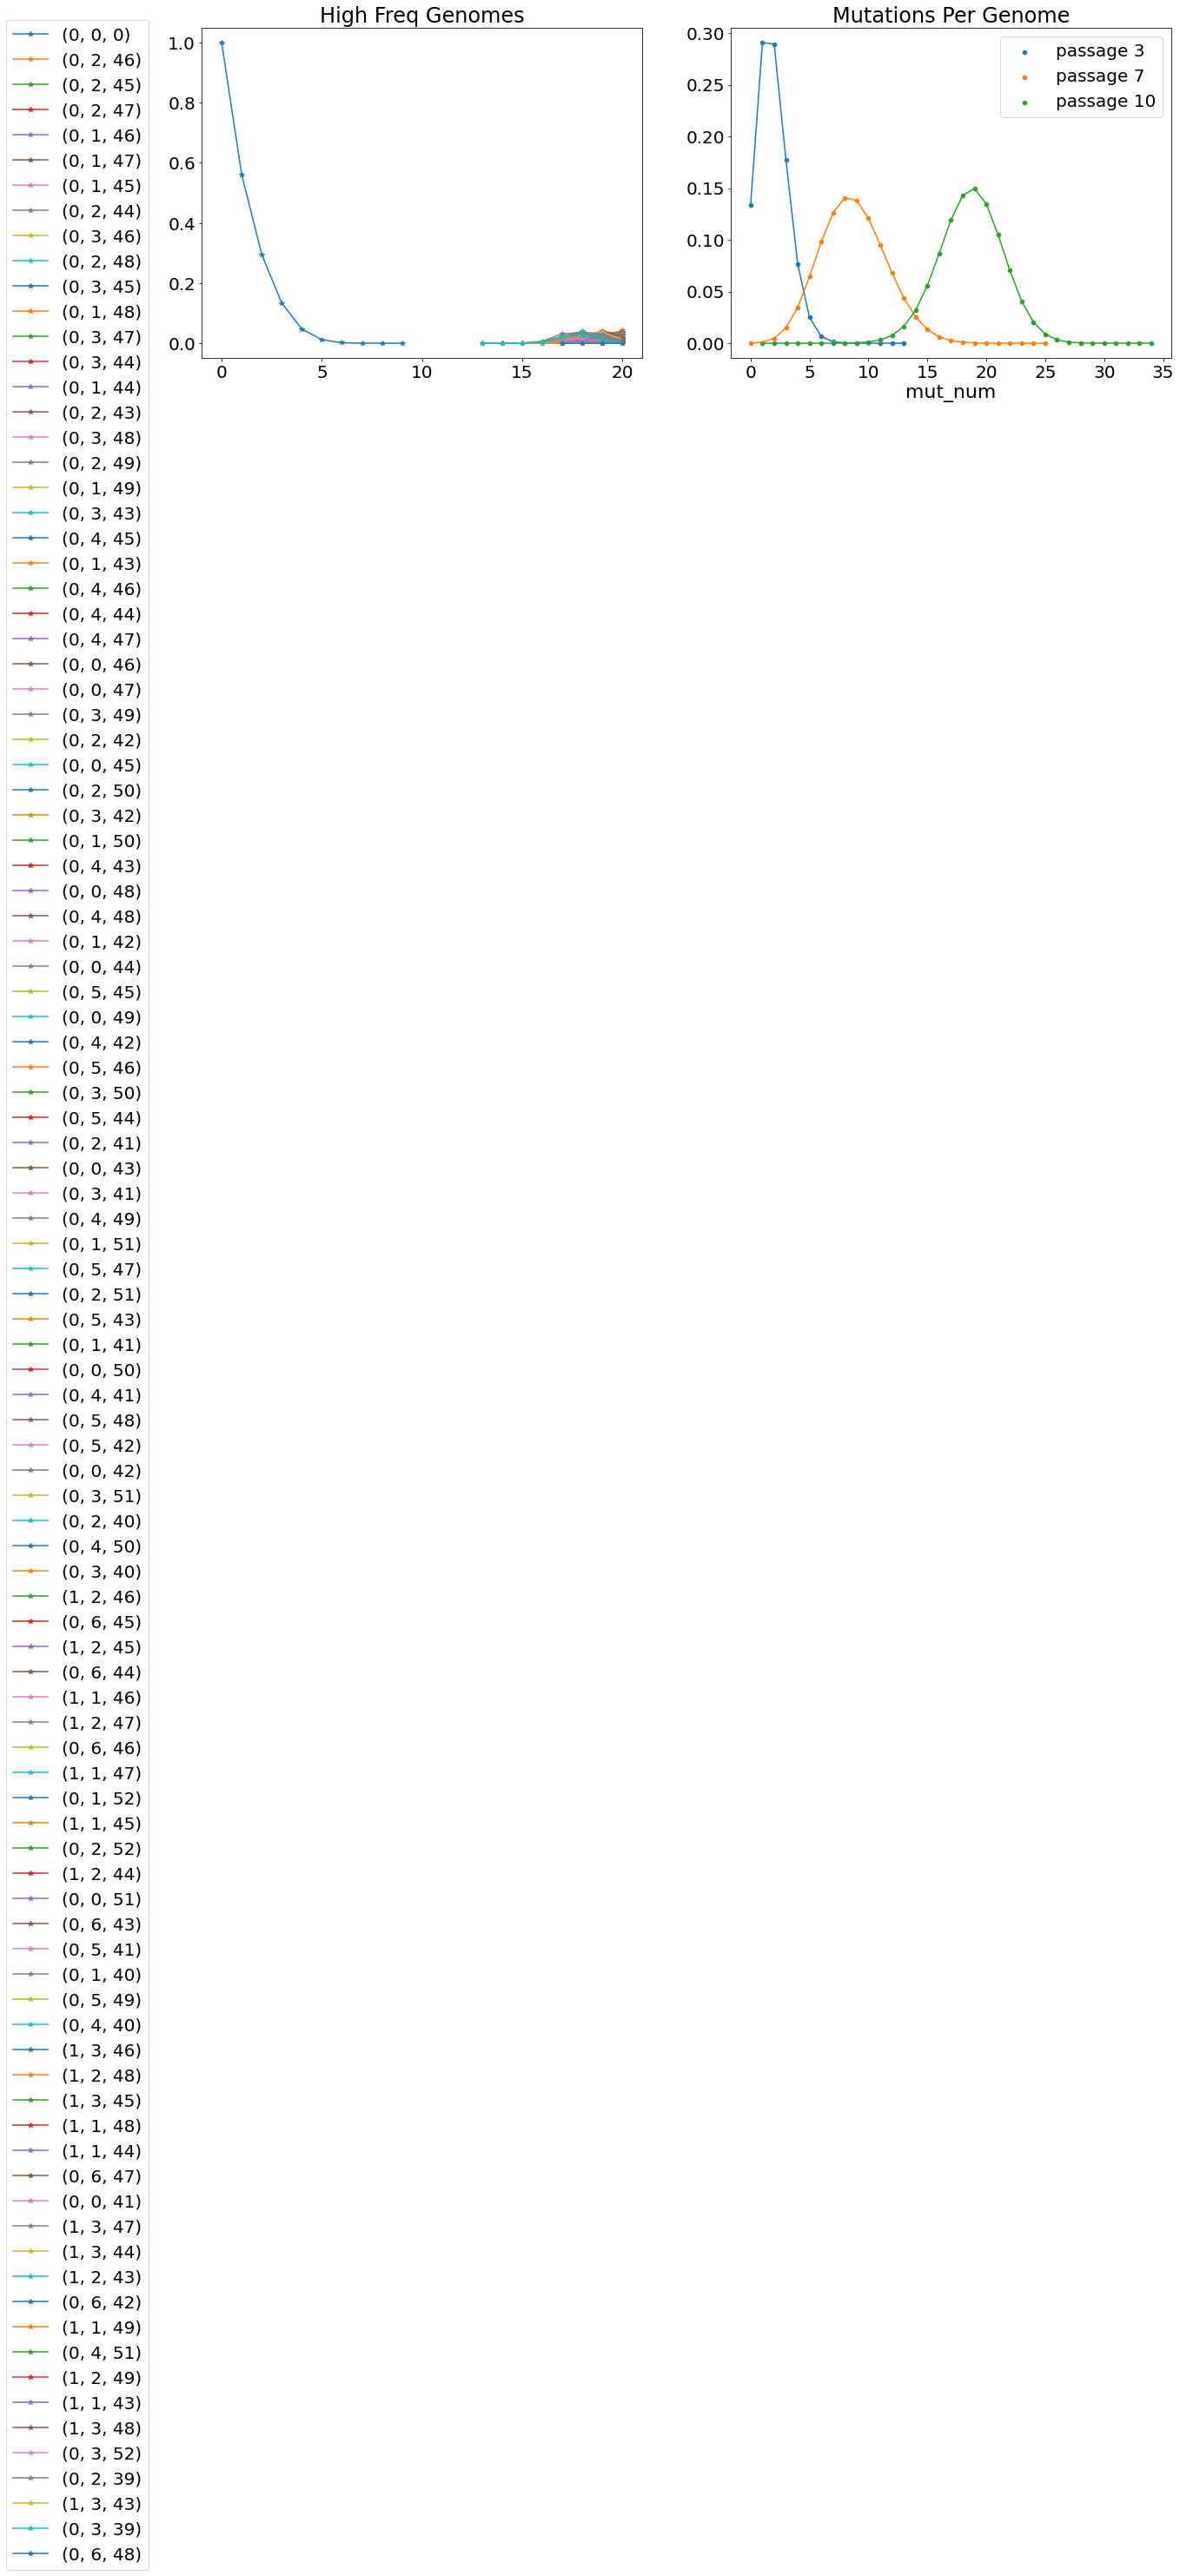

In [182]:
fitness_distribution = np.array([0.4, 0.4, 0.2])
fitness_values = np.array([0.2, 1, 1.5])
passages = 20
genomes_to_plot = 100
passages_to_plot = [3,7,10]
data = run_n_plot(fitness_distribution, fitness_values, mutation_rate, passages, genomes_to_plot, passages_to_plot)

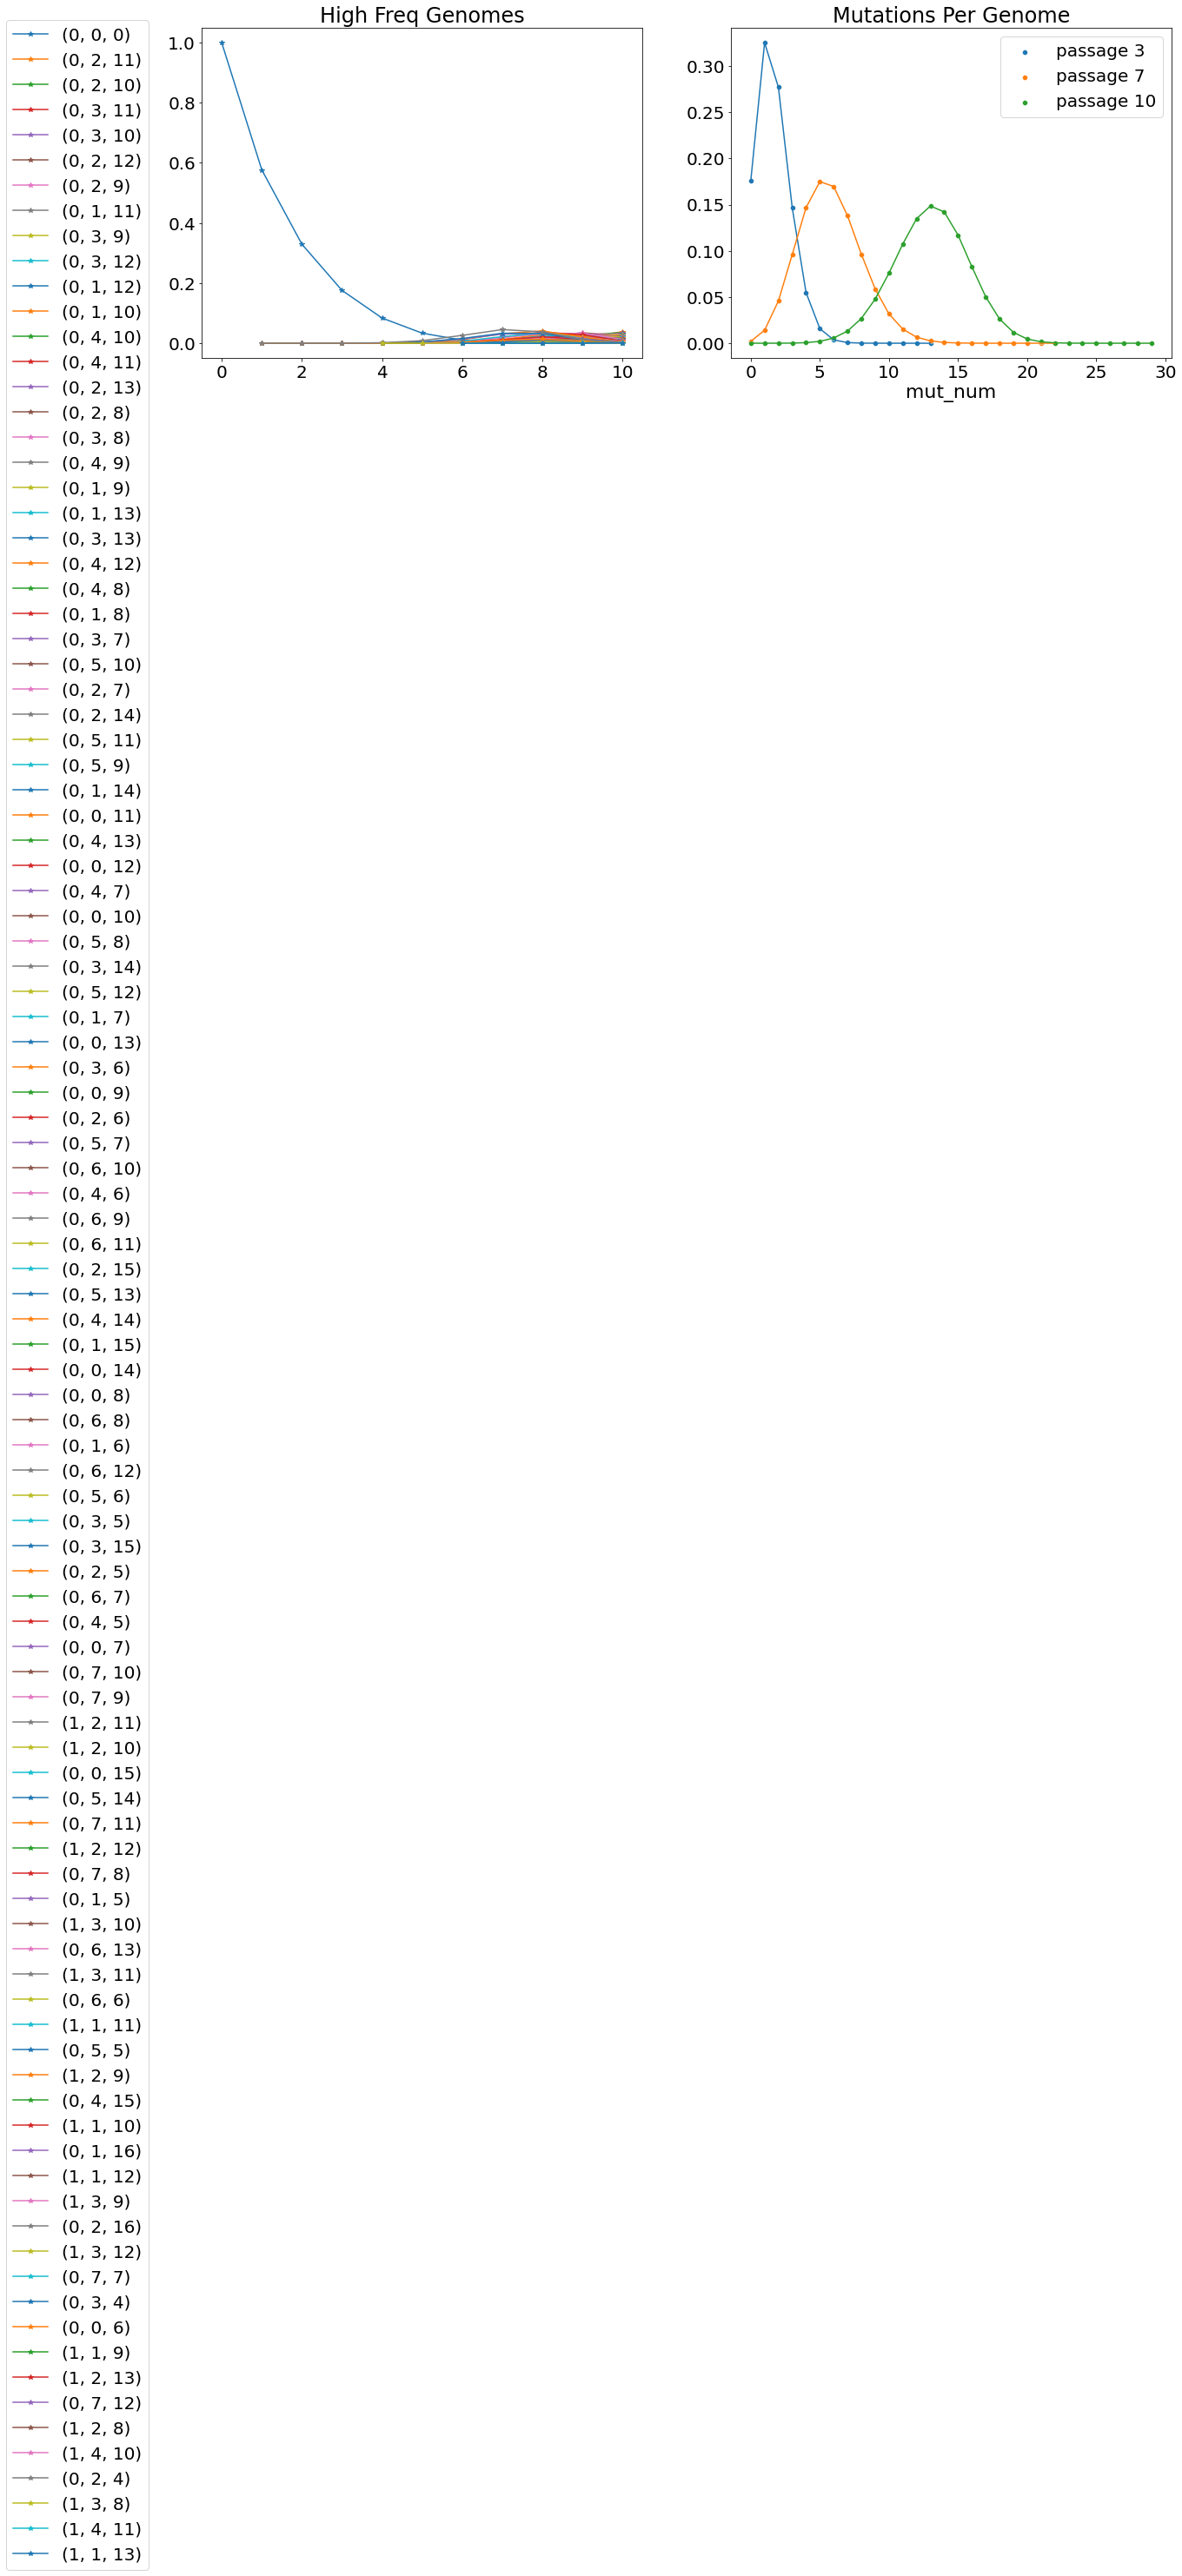

In [184]:
fitness_distribution = np.array([0.4, 0.5, 0.1])
fitness_values = np.array([0.2, 1, 1.5])
passages = 10
genomes_to_plot = 100
passages_to_plot = [3,7,10]
data = run_n_plot(fitness_distribution, fitness_values, mutation_rate, passages, genomes_to_plot, passages_to_plot)

In [149]:
data

0             1             2             3             4  \
0 0 0  1.0  9.920319e-01  9.919526e-01  9.919518e-01  9.919518e-01   
1 0 0  NaN  7.936255e-03  8.014977e-03  8.015764e-03  8.015772e-03   
2 0 0  NaN  3.174502e-05  3.238051e-05  3.238689e-05  3.238696e-05   
3 0 0  NaN  8.465339e-08  8.721150e-08  8.723733e-08  8.723759e-08   
4 0 0  NaN  1.693068e-10  1.761672e-10  1.762369e-10  1.762376e-10   

                  5             6             7             8             9  \
0 0 0  9.919518e-01  9.919518e-01  9.919518e-01  9.919518e-01  9.919518e-01   
1 0 0  8.015772e-03  8.015772e-03  8.015772e-03  8.015772e-03  8.015772e-03   
2 0 0  3.238696e-05  3.238696e-05  3.238696e-05  3.238696e-05  3.238696e-05   
3 0 0  8.723759e-08  8.723759e-08  8.723759e-08  8.723759e-08  8.723759e-08   
4 0 0  1.762376e-10  1.762376e-10  1.762376e-10  1.762376e-10  1.762376e-10   

                 10  mut_num  
0 0 0  9.919518e-01        0  
1 0 0  8.015772e-03        1  
2 0 0  3.238696e-05        2  
3 0 0  8.723759e-08        3  
4 0 0  1.762376e-10        4

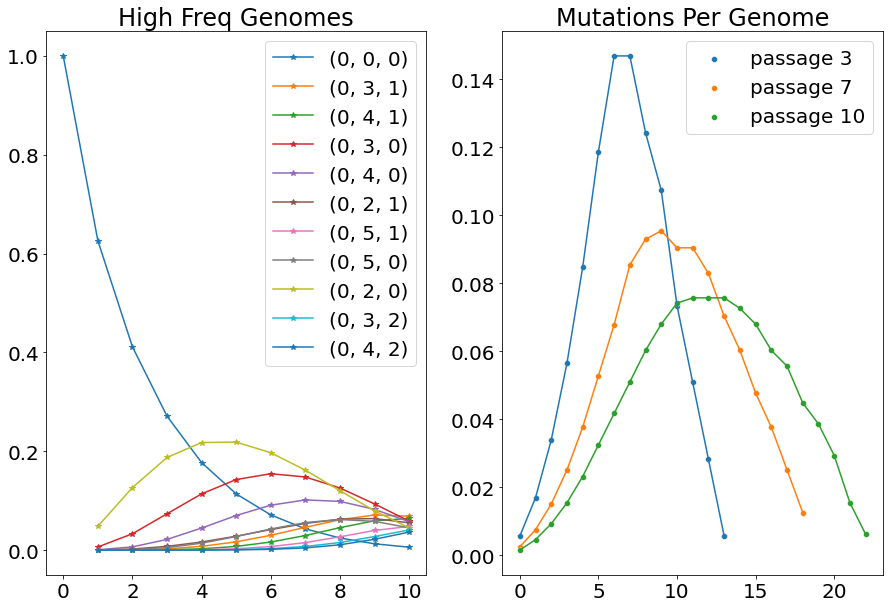

In [47]:
plot_data(data)

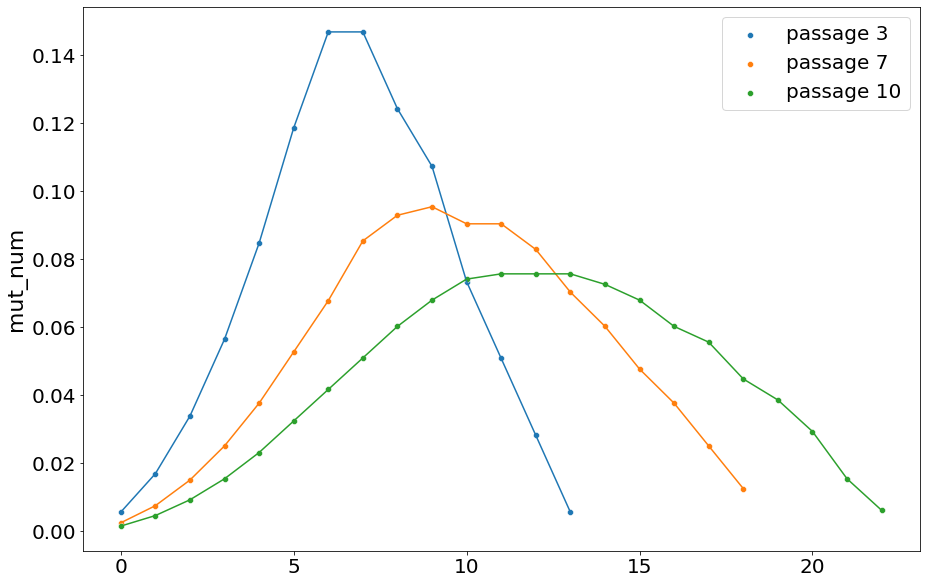

In [34]:
num_of_muts = dict()
for i in [3,7,10]:
    num_of_muts[i] = data[data[i].notna()].mut_num.value_counts(normalize=True)
    sns.scatterplot(data=num_of_muts[i], label=f'passage {i}')
    sns.lineplot(data=num_of_muts[i])


In [19]:
data

0             1         2         3         4         5         6  \
0 0  0  1.0  6.261805e-01  0.411402  0.271125  0.177058  0.113745  0.071249   
     1  NaN  7.514166e-03  0.012342  0.015454  0.017263  0.018000  0.017768   
     2  NaN  4.508499e-05  0.000185  0.000440  0.000842  0.001424  0.002215   
     3  NaN  1.803400e-07  0.000002  0.000008  0.000027  0.000075  0.000184   
  1  0  NaN  2.454627e-01  0.322539  0.318843  0.277628  0.222940  0.167579   
...     ...           ...       ...       ...       ...       ...       ...   
  21 1  NaN           NaN       NaN       NaN       NaN       NaN       NaN   
  9  8  NaN           NaN       NaN       NaN       NaN       NaN       NaN   
  14 6  NaN           NaN       NaN       NaN       NaN       NaN       NaN   
1 13 6  NaN           NaN       NaN       NaN       NaN       NaN       NaN   
0 12 7  NaN           NaN       NaN       NaN       NaN       NaN       NaN   

               7         8         9            10  \
0 0  0  0.042961  0.024457  0.012766  5.847337e-03   
     1  0.016586  0.014457  0.011472  7.952150e-03   
     2  0.003202  0.004273  0.005155  5.407307e-03   
     3  0.000412  0.000842  0.001544  2.451242e-03   
  1  0  0.117886  0.076698  0.045039  2.292156e-02   
...          ...       ...       ...           ...   
  21 1       NaN       NaN       NaN  1.416423e-10   
  9  8       NaN       NaN       NaN  4.849977e-10   
  14 6       NaN       NaN       NaN  4.889425e-10   
1 13 6       NaN       NaN       NaN  1.100076e-10   
0 12 7       NaN       NaN       NaN  2.909202e-10   

                               mut_num  
0 0  0  <map object at 0x7f10d6a59d10>  
     1  <map object at 0x7f10d6a59d10>  
     2  <map object at 0x7f10d6a59d10>  
     3  <map object at 0x7f10d6a59d10>  
  1  0  <map object at 0x7f10d6a59d10>  
...                                ...  
  21 1  <map object at 0x7f10d6a59d10>  
  9  8  <map object at 0x7f10d6a59d10>  
  14 6  <map object at 0x7f10d6a59d10>  
1 13 6  <map object at 0x7f10d6a59d10>  
0 12 7  <map object at 0x7f10d6a59d10>  

[651 rows x 12 columns]

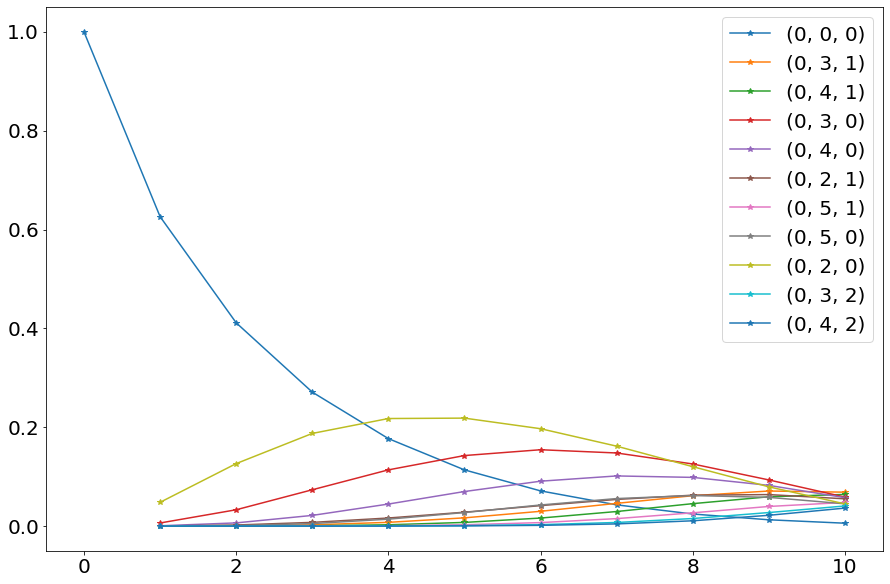

In [7]:
rising_muts = data.sort_values(by=data.columns.max(), ascending=False).head(10).index
plt.plot(data.loc[(0,0,0), 0:], label=(0,0,0), marker='*')
for mut in rising_muts:
    plt.plot(data.loc[mut, 0:], label=mut, marker='*')
plt.legend(bbox_to_anchor=(1,1))